# マップ毎にブキの強さを推定する

Date: 2017-03-10  
Author: haigno3000

- マップ毎にブキの強さを求める
- マップ毎のブキの強さの平均・標準偏差・最大 - 最小

In [18]:
import tqdm

In [47]:
experiment_name = 'bukimapcorr'

In [19]:
datapath = '/Users/tnishibayashi/dev/workspace/ika-mining/data/battles_20160517.tsv'

In [21]:
df = pd.read_csv(datapath, sep='\t', index_col='id', usecols=[
        'id', 'is_win', 'rule_name', 'map_name',
        'friend1_weapon',
        'friend1_weapon_type',
        'friend2_weapon',
        'friend3_weapon',
        'friend4_weapon',
        'enemy1_weapon',
        'enemy2_weapon',
        'enemy3_weapon',
        'enemy4_weapon',
    ])

In [28]:
df['counter'] = 1

In [29]:
df.rule_name.unique()

array(['area', 'nawabari', nan, 'hoko', 'yagura'], dtype=object)

In [290]:
map_names = df.map_name.dropna().unique()
map_names

array(['shionome', 'hakofugu', 'dekaline', 'mongara', 'mozuku', 'arowana',
       'bbass', 'hokke', 'tachiuo', 'negitoro', 'masaba', 'hirame',
       'kinmedai', 'anchovy', 'shottsuru', 'mahimahi'], dtype=object)

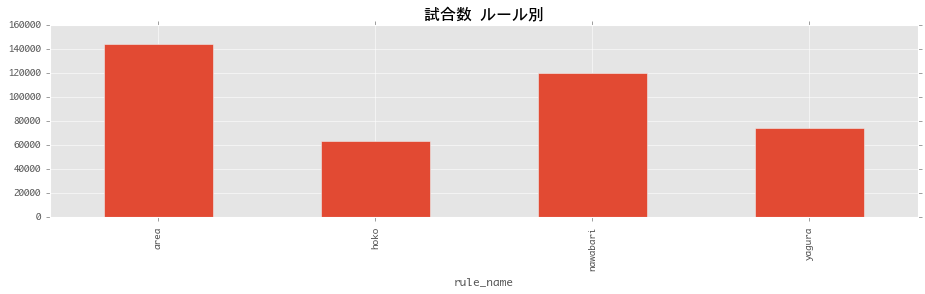

In [145]:
df.groupby('rule_name').count()['counter'].plot(kind='bar', title='試合数 ルール別', figsize=(14, 3))

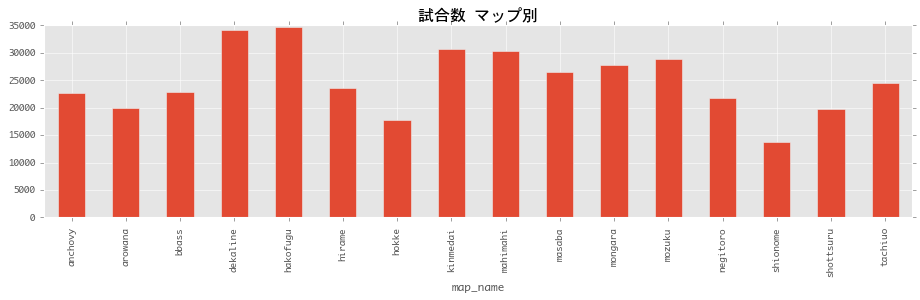

In [144]:
df.groupby('map_name').count()['counter'].plot(kind='bar', title='試合数 マップ別', figsize=(14, 3))

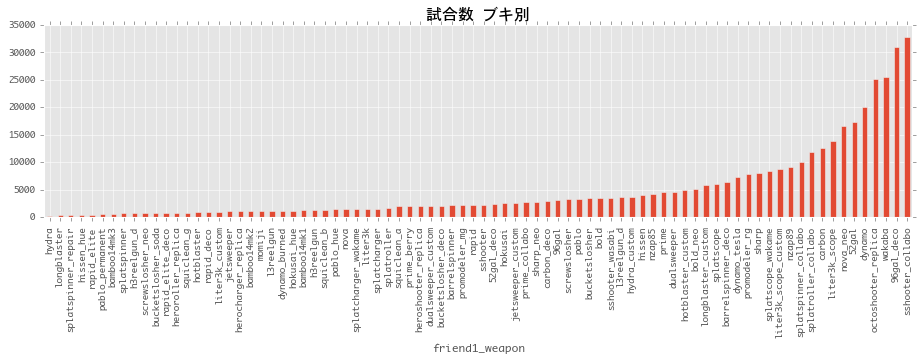

In [154]:
df.groupby('friend1_weapon').count()['counter'].sort_values().plot(kind='bar', title='試合数 ブキ別', figsize=(14, 3))

In [37]:
# エリアバトル
df_area_battle = df.query('rule_name == "area"').copy()

In [38]:
# ナワバリバトル
df_nawabari_battle = df.query('rule_name == "nawabari"').copy()

In [39]:
m = df.groupby(['friend1_weapon', 'friend1_weapon_type']).count().index

In [40]:
buki_names = []
buki_category = []
for v in m.values:
    buki_names.append(v[0])
    buki_category.append(v[1])

In [99]:
buki_category_df = pd.DataFrame({'category': buki_category}, index=buki_names)

In [98]:
buki_df.head()

,category
52gal,shooter
52gal_deco,shooter
96gal,shooter
96gal_deco,shooter
bamboo14mk1,charger


In [43]:
def count_buki(team, buki):
    def fn(df):
        count = 0
        for i in range(1, 5):
            count += 1 if df['{0}{1}_weapon'.format(team, i)] == buki else 0
        return count
    return fn

In [250]:
popular_buki_names = df.groupby('friend1_weapon').count()['counter'].sort_values().tail(40).index.values

In [226]:
def extract_feature(_df):
    for buki in tqdm.tqdm(buki_names):
        _df['friend_{0}_num'.format(buki)] = _df.apply(count_buki('friend', buki), axis=1)
        _df['enemy_{0}_num'.format(buki)] = _df.apply(count_buki('enemy', buki), axis=1)
        _df['{0}_diff'.format(buki)] = _df['friend_{0}_num'.format(buki)] - _df['enemy_{0}_num'.format(buki)]
    return _df

In [227]:
df_area_battle_ex = extract_feature(df_area_battle)
df_nawabari_battle_ex = extract_feature(df_nawabari_battle)

100%|██████████| 82/82 [30:39<00:00, 22.32s/it]


In [228]:
df_area_battle_ex.head()

,rule_name,map_name,is_win,friend1_weapon,friend1_weapon_type,friend2_weapon,friend3_weapon,friend4_weapon,enemy1_weapon,enemy2_weapon,...,25202_diff,friend_25458_num,enemy_25458_num,25458_diff,friend_30947_num,enemy_30947_num,30947_diff,friend_32783_num,enemy_32783_num,32783_diff
id,,,,,,,,,,,,,,,,,,,,,
500000,area,shionome,0,wakaba,shooter,wakaba,52gal,dynamo,barrelspinner_deco,dynamo,...,0,0,0,0,0,0,0,0,0,0
500002,area,hakofugu,1,sshooter_collabo,shooter,96gal_deco,barrelspinner,dynamo,splatspinner_collabo,wakaba,...,0,0,0,0,0,0,0,0,0,0
500003,area,hakofugu,1,wakaba,shooter,hissen,hydra_custom,96gal_deco,octoshooter_replica,jetsweeper_custom,...,0,0,0,0,0,0,0,0,0,0
500007,area,shionome,1,sshooter_collabo,shooter,wakaba,splatscope,52gal,splatscope,sshooter_collabo,...,0,0,0,0,0,0,0,0,0,0
500008,area,hakofugu,0,wakaba,shooter,52gal,sshooter_collabo,sshooter_collabo,96gal,octoshooter_replica,...,0,0,0,0,0,0,0,0,0,0


In [229]:
df_area_battle_ex.to_pickle('./{}_df_area_battle.pickle'.format(experiment_name))
df_nawabari_battle_ex.to_pickle('./{}_df_nawabari_battle.pickle'.format(experiment_name))

## マップ毎にブキの強さを学習する

In [230]:
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [231]:
def cross_val(X, y, K, random_state=0, clf=None):
    cv = KFold(len(y), K, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=cv)
    #print('Scores:', scores)
    print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))
    return scores

In [232]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    target_names = ['lose', 'win']

    tick_marks = np.arange(len(target_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(target_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(target_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()

In [233]:
def calc_classifier(X_train, y_train, with_confusion_matrix=True):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.90, random_state=13)
    print('Num of Training Samples: {}'.format(len(X_train)))
    print('Num of Validation Samples: {}'.format(len(X_val)))
    #clf = LogisticRegression(penalty='l2',  fit_intercept=False).fit(X_train, y_train)
    #バイアス項あり
    clf = LogisticRegression(penalty='l2',  fit_intercept=True).fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))
    if with_confusion_matrix:
        cm = confusion_matrix(y_val, y_val_pred)
        plot_confusion_matrix(cm)
    return clf

### エリアバトル

In [292]:
_d = df_area_battle_ex
results = {}
for map_name in map_names:
    print(map_name)
    y_train = _d[_d.map_name == map_name].is_win
    X_train = _d[_d.map_name == map_name][['{0}_diff'.format(buki) for buki in buki_names]]
    clf = calc_classifier(X_train, y_train, with_confusion_matrix=False)
    results[map_name] = clf.coef_[0]

shionome
Num of Training Samples: 7218
Num of Validation Samples: 802
Accuracy on Training Set: 0.595
Accuracy on Validation Set: 0.585
hakofugu
Num of Training Samples: 14426
Num of Validation Samples: 1603
Accuracy on Training Set: 0.603
Accuracy on Validation Set: 0.608
dekaline
Num of Training Samples: 8460
Num of Validation Samples: 940
Accuracy on Training Set: 0.593
Accuracy on Validation Set: 0.598
mongara
Num of Training Samples: 8431
Num of Validation Samples: 937
Accuracy on Training Set: 0.575
Accuracy on Validation Set: 0.559
mozuku
Num of Training Samples: 7550
Num of Validation Samples: 839
Accuracy on Training Set: 0.638
Accuracy on Validation Set: 0.613
arowana
Num of Training Samples: 4887
Num of Validation Samples: 543
Accuracy on Training Set: 0.589
Accuracy on Validation Set: 0.586
bbass
Num of Training Samples: 6734
Num of Validation Samples: 749
Accuracy on Training Set: 0.598
Accuracy on Validation Set: 0.566
hokke
Num of Training Samples: 4275
Num of Validation

In [263]:
result_df = pd.DataFrame(results, index=buki_names)
# ステージ毎の強さの平均
result_df['mean'] = result_df.mean(axis=1)
# ステージ毎の強さの標準偏差
result_df['std'] = result_df.std(axis=1)
# 得意なステージと不得意なステージの差
result_df['diff'] = result_df.max(axis=1) - result_df.min(axis=1)
area_battle_result_df = buki_category_df.ix[popular_buki_names].join(result_df)

In [272]:
# 得意なマップと不得意なマップで強さの差が大きいブキ
area_battle_result_df.sort_values(by='diff', ascending=False).head(15)

,category,anchovy,arowana,bbass,dekaline,hakofugu,hirame,hokke,kinmedai,mahimahi,masaba,mongara,mozuku,negitoro,shionome,shottsuru,tachiuo,mean,std,diff
liter3k_scope_custom,charger,-0.211287,-0.104201,-0.099433,-0.169231,-0.202822,-0.378106,-0.179547,0.083003,0.067106,-0.217983,0.051340,-0.462489,-0.040371,0.031079,-0.197038,0.043272,-0.124169,0.154598,0.617087
carbon_deco,roller,-0.411511,-0.184033,-0.258126,-0.294514,-0.004274,-0.266021,-0.035112,-0.319290,-0.439871,-0.243060,-0.471484,-0.135910,-0.462473,-0.290172,-0.231091,-0.116182,-0.260195,0.138210,0.609694
splatspinner_collabo,splatling,0.259712,0.121400,0.074145,0.403355,0.373110,0.355300,0.297644,0.470287,0.419374,0.290596,0.513490,0.422328,0.238458,0.272417,0.337744,-0.066071,0.298955,0.147365,0.579561
nzap85,shooter,-0.017351,0.126126,0.124050,0.023924,0.178296,0.296691,0.170721,-0.258128,0.022339,0.142595,0.160402,0.103754,0.270605,0.130457,-0.017397,0.263339,0.107526,0.132286,0.554819
96gal,shooter,-0.002070,0.331606,0.245716,0.209826,0.147374,0.480559,0.377051,0.523010,0.257433,0.364060,0.338974,0.185192,0.485243,0.449389,0.327930,-0.003654,0.294852,0.155060,0.526663
hokusai,roller,-0.046570,-0.151173,0.236691,0.087514,0.027312,0.292054,-0.228689,-0.053220,0.066126,0.040462,0.022305,-0.065656,0.035971,0.008942,0.085893,-0.032281,0.020355,0.123455,0.520743
barrelspinner_deco,splatling,0.019192,0.025045,0.154811,0.275059,0.164427,-0.045116,0.124191,0.230262,-0.037177,0.209593,0.267062,0.200948,0.355165,-0.024137,-0.030600,-0.152238,0.108530,0.140873,0.507403
pablo,roller,0.197371,0.109534,0.320318,0.065435,0.064386,0.439969,-0.004147,0.203548,0.070774,-0.064380,0.079483,-0.019489,0.066930,0.136363,0.309697,0.208391,0.136511,0.131602,0.504349
longblaster_custom,shooter,0.162795,0.398156,0.131625,0.117831,0.135923,0.163696,0.005962,0.082625,-0.052591,0.117509,0.149526,-0.040549,0.176577,0.091907,0.058780,-0.084408,0.100960,0.110699,0.482564
hotblaster_custom,shooter,-0.178433,-0.127005,0.173513,0.298309,0.119250,0.192943,-0.007728,-0.034416,-0.025773,0.014168,-0.013752,-0.044583,0.165538,0.005969,0.063788,0.044758,0.040409,0.119943,0.476742


In [265]:
# マップによって強さの差が小さいブキ
area_battle_result_df.sort_values(by='diff', ascending=False).tail(5)

,category,anchovy,arowana,bbass,dekaline,hakofugu,hirame,hokke,kinmedai,mahimahi,masaba,mongara,mozuku,negitoro,shionome,shottsuru,tachiuo,mean,std,diff
sshooter_wasabi,shooter,0.111910,0.267698,0.153043,0.185495,0.164337,0.184621,0.226053,0.196831,0.189947,0.236616,0.233029,0.230869,0.043644,0.036173,0.072313,0.329931,0.178907,0.078180,0.293758
96gal_deco,shooter,0.106699,0.062164,0.259873,0.200197,0.111064,0.125757,0.126778,0.186767,0.190162,0.052223,0.284461,0.175348,0.225965,0.182584,0.203853,0.103931,0.162364,0.064943,0.232237
nova_neo,shooter,0.133452,0.066212,0.202720,0.183347,0.095078,0.168011,0.205214,0.074204,0.075319,0.117852,0.050025,0.131985,0.175526,0.076958,-0.002757,0.215360,0.123032,0.062353,0.218117
octoshooter_replica,shooter,0.241408,0.074627,0.231557,0.231336,0.181653,0.225437,0.199914,0.204257,0.184668,0.114433,0.236840,0.158478,0.221403,0.193190,0.180078,0.182217,0.191343,0.044066,0.197341
sshooter_collabo,shooter,0.124439,0.192947,0.204627,0.153119,0.141571,0.068552,0.193961,0.080154,0.157388,0.055810,0.054335,0.166852,0.097383,0.095321,0.035226,0.176772,0.124903,0.054164,0.169401


(-0.4, 0.7)

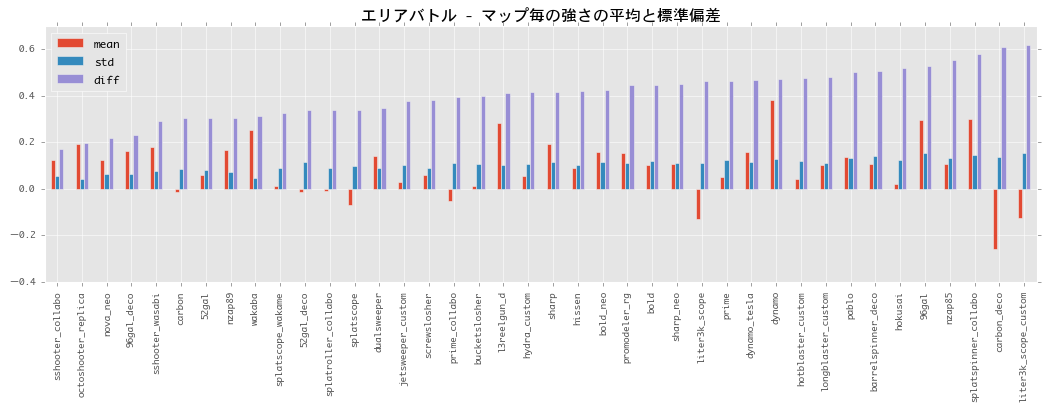

In [266]:
area_battle_result_df.sort_values(by='diff')[['mean', 'std', 'diff']].plot(kind='bar', figsize=(16, 4), title='エリアバトル - マップ毎の強さの平均と標準偏差')
plt.ylim(-0.4, 0.7)

In [311]:
_ret = {}
for map_name in map_names:
    top = area_battle_result_df[map_name].sort_values(ascending=False)
    _ret[map_name + '_buki_name'] = top.index.values
    _ret[map_name + '_buki_power'] = top.values

In [312]:
area_battle_ranking_df = pd.DataFrame(_ret)
area_battle_ranking_df.head()

,anchovy_buki_name,anchovy_buki_power,arowana_buki_name,arowana_buki_power,bbass_buki_name,bbass_buki_power,dekaline_buki_name,dekaline_buki_power,hakofugu_buki_name,hakofugu_buki_power,...,mozuku_buki_name,mozuku_buki_power,negitoro_buki_name,negitoro_buki_power,shionome_buki_name,shionome_buki_power,shottsuru_buki_name,shottsuru_buki_power,tachiuo_buki_name,tachiuo_buki_power
0,l3reelgun_d,0.436586,longblaster_custom,0.398156,dynamo,0.419725,dynamo,0.428297,splatspinner_collabo,0.373110,...,dynamo,0.472252,96gal,0.485243,96gal,0.449389,dynamo,0.568121,sharp,0.380653
1,dynamo,0.327059,promodeler_rg,0.397654,l3reelgun_d,0.330005,splatspinner_collabo,0.403355,dynamo,0.332771,...,splatspinner_collabo,0.422328,barrelspinner_deco,0.355165,dynamo,0.407409,l3reelgun_d,0.513921,dynamo,0.369518
2,wakaba,0.317475,96gal,0.331606,pablo,0.320318,l3reelgun_d,0.327780,l3reelgun_d,0.263805,...,l3reelgun_d,0.300430,bold_neo,0.325470,wakaba,0.304652,splatspinner_collabo,0.337744,sshooter_wasabi,0.329931
3,sharp,0.271426,wakaba,0.280737,sharp,0.268282,wakaba,0.303693,wakaba,0.239304,...,sharp,0.282379,sharp,0.279156,bold,0.301167,96gal,0.327930,dynamo_tesla,0.315056
4,splatspinner_collabo,0.259712,dynamo,0.269109,96gal_deco,0.259873,hotblaster_custom,0.298309,octoshooter_replica,0.181653,...,dualsweeper,0.235457,nzap85,0.270605,sharp,0.284503,pablo,0.309697,l3reelgun_d,0.297792


In [316]:
area_battle_ranking_df.to_excel(experiment_name + '_area_battle_ranking_df.xls')
area_battle_result_df.to_excel(experiment_name + '_area_battle_buki_power.xls')

### ナワバリバトル

In [291]:
_d = df_nawabari_battle_ex
results = {}
for map_name in map_names:
    print(map_name)
    y_train = _d[_d.map_name == map_name].is_win
    X_train = _d[_d.map_name == map_name][['{0}_diff'.format(buki) for buki in buki_names]]
    clf = calc_classifier(X_train, y_train, with_confusion_matrix=False)
    results[map_name] = clf.coef_[0]

shionome
Num of Training Samples: 4715
Num of Validation Samples: 524
Accuracy on Training Set: 0.627
Accuracy on Validation Set: 0.563
hakofugu
Num of Training Samples: 7551
Num of Validation Samples: 840
Accuracy on Training Set: 0.602
Accuracy on Validation Set: 0.570
dekaline
Num of Training Samples: 12504
Num of Validation Samples: 1390
Accuracy on Training Set: 0.625
Accuracy on Validation Set: 0.627
mongara
Num of Training Samples: 8676
Num of Validation Samples: 964
Accuracy on Training Set: 0.651
Accuracy on Validation Set: 0.641
mozuku
Num of Training Samples: 7884
Num of Validation Samples: 877
Accuracy on Training Set: 0.624
Accuracy on Validation Set: 0.596
arowana
Num of Training Samples: 3113
Num of Validation Samples: 346
Accuracy on Training Set: 0.618
Accuracy on Validation Set: 0.581
bbass
Num of Training Samples: 8296
Num of Validation Samples: 922
Accuracy on Training Set: 0.603
Accuracy on Validation Set: 0.603
hokke
Num of Training Samples: 7584
Num of Validation

In [267]:
result_df = pd.DataFrame(results, index=buki_names)
# ステージ毎の強さの平均
result_df['mean'] = result_df.mean(axis=1)
# ステージ毎の強さの標準偏差
result_df['std'] = result_df.std(axis=1)
# 得意なステージと不得意なステージの差
result_df['diff'] = result_df.max(axis=1) - result_df.min(axis=1)
nawabari_battle_result_df = buki_category_df.ix[popular_buki_names].join(result_df)

In [268]:
nawabari_battle_result_df.sort_values(by='diff', ascending=False).head(10)

,category,anchovy,arowana,bbass,dekaline,hakofugu,hirame,hokke,kinmedai,mahimahi,masaba,mongara,mozuku,negitoro,shionome,shottsuru,tachiuo,mean,std,diff
liter3k_scope_custom,charger,-0.211287,-0.104201,-0.099433,-0.169231,-0.202822,-0.378106,-0.179547,0.083003,0.067106,-0.217983,0.051340,-0.462489,-0.040371,0.031079,-0.197038,0.043272,-0.124169,0.154598,0.617087
carbon_deco,roller,-0.411511,-0.184033,-0.258126,-0.294514,-0.004274,-0.266021,-0.035112,-0.319290,-0.439871,-0.243060,-0.471484,-0.135910,-0.462473,-0.290172,-0.231091,-0.116182,-0.260195,0.138210,0.609694
splatspinner_collabo,splatling,0.259712,0.121400,0.074145,0.403355,0.373110,0.355300,0.297644,0.470287,0.419374,0.290596,0.513490,0.422328,0.238458,0.272417,0.337744,-0.066071,0.298955,0.147365,0.579561
nzap85,shooter,-0.017351,0.126126,0.124050,0.023924,0.178296,0.296691,0.170721,-0.258128,0.022339,0.142595,0.160402,0.103754,0.270605,0.130457,-0.017397,0.263339,0.107526,0.132286,0.554819
96gal,shooter,-0.002070,0.331606,0.245716,0.209826,0.147374,0.480559,0.377051,0.523010,0.257433,0.364060,0.338974,0.185192,0.485243,0.449389,0.327930,-0.003654,0.294852,0.155060,0.526663
hokusai,roller,-0.046570,-0.151173,0.236691,0.087514,0.027312,0.292054,-0.228689,-0.053220,0.066126,0.040462,0.022305,-0.065656,0.035971,0.008942,0.085893,-0.032281,0.020355,0.123455,0.520743
barrelspinner_deco,splatling,0.019192,0.025045,0.154811,0.275059,0.164427,-0.045116,0.124191,0.230262,-0.037177,0.209593,0.267062,0.200948,0.355165,-0.024137,-0.030600,-0.152238,0.108530,0.140873,0.507403
pablo,roller,0.197371,0.109534,0.320318,0.065435,0.064386,0.439969,-0.004147,0.203548,0.070774,-0.064380,0.079483,-0.019489,0.066930,0.136363,0.309697,0.208391,0.136511,0.131602,0.504349
longblaster_custom,shooter,0.162795,0.398156,0.131625,0.117831,0.135923,0.163696,0.005962,0.082625,-0.052591,0.117509,0.149526,-0.040549,0.176577,0.091907,0.058780,-0.084408,0.100960,0.110699,0.482564
hotblaster_custom,shooter,-0.178433,-0.127005,0.173513,0.298309,0.119250,0.192943,-0.007728,-0.034416,-0.025773,0.014168,-0.013752,-0.044583,0.165538,0.005969,0.063788,0.044758,0.040409,0.119943,0.476742


In [269]:
nawabari_battle_result_df.sort_values(by='diff', ascending=False).tail(5)

,category,anchovy,arowana,bbass,dekaline,hakofugu,hirame,hokke,kinmedai,mahimahi,masaba,mongara,mozuku,negitoro,shionome,shottsuru,tachiuo,mean,std,diff
sshooter_wasabi,shooter,0.111910,0.267698,0.153043,0.185495,0.164337,0.184621,0.226053,0.196831,0.189947,0.236616,0.233029,0.230869,0.043644,0.036173,0.072313,0.329931,0.178907,0.078180,0.293758
96gal_deco,shooter,0.106699,0.062164,0.259873,0.200197,0.111064,0.125757,0.126778,0.186767,0.190162,0.052223,0.284461,0.175348,0.225965,0.182584,0.203853,0.103931,0.162364,0.064943,0.232237
nova_neo,shooter,0.133452,0.066212,0.202720,0.183347,0.095078,0.168011,0.205214,0.074204,0.075319,0.117852,0.050025,0.131985,0.175526,0.076958,-0.002757,0.215360,0.123032,0.062353,0.218117
octoshooter_replica,shooter,0.241408,0.074627,0.231557,0.231336,0.181653,0.225437,0.199914,0.204257,0.184668,0.114433,0.236840,0.158478,0.221403,0.193190,0.180078,0.182217,0.191343,0.044066,0.197341
sshooter_collabo,shooter,0.124439,0.192947,0.204627,0.153119,0.141571,0.068552,0.193961,0.080154,0.157388,0.055810,0.054335,0.166852,0.097383,0.095321,0.035226,0.176772,0.124903,0.054164,0.169401


(-0.4, 0.7)

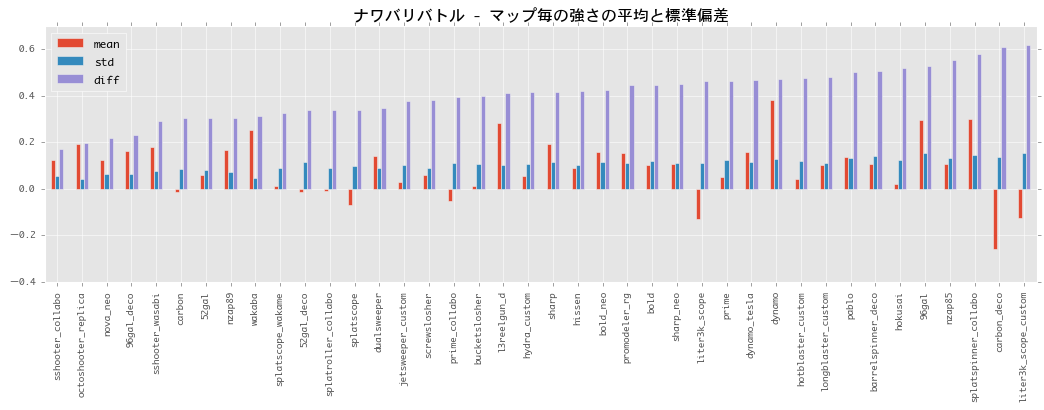

In [271]:
nawabari_battle_result_df.sort_values(by='diff')[['mean', 'std', 'diff']].plot(kind='bar', figsize=(16, 4), title='ナワバリバトル - マップ毎の強さの平均と標準偏差')
plt.ylim(-0.4, 0.7)

In [308]:
_ret = {}
for map_name in map_names:
    top = nawabari_battle_result_df[map_name].sort_values(ascending=False)
    _ret[map_name + '_buki_name'] = top.index.values
    _ret[map_name + '_buki_power'] = top.values

In [309]:
nawabari_battle_ranking_df = pd.DataFrame(_ret)
nawabari_battle_ranking_df.head()

,anchovy_buki_name,anchovy_buki_power,arowana_buki_name,arowana_buki_power,bbass_buki_name,bbass_buki_power,dekaline_buki_name,dekaline_buki_power,hakofugu_buki_name,hakofugu_buki_power,...,mozuku_buki_name,mozuku_buki_power,negitoro_buki_name,negitoro_buki_power,shionome_buki_name,shionome_buki_power,shottsuru_buki_name,shottsuru_buki_power,tachiuo_buki_name,tachiuo_buki_power
0,l3reelgun_d,0.436586,longblaster_custom,0.398156,dynamo,0.419725,dynamo,0.428297,splatspinner_collabo,0.373110,...,dynamo,0.472252,96gal,0.485243,96gal,0.449389,dynamo,0.568121,sharp,0.380653
1,dynamo,0.327059,promodeler_rg,0.397654,l3reelgun_d,0.330005,splatspinner_collabo,0.403355,dynamo,0.332771,...,splatspinner_collabo,0.422328,barrelspinner_deco,0.355165,dynamo,0.407409,l3reelgun_d,0.513921,dynamo,0.369518
2,wakaba,0.317475,96gal,0.331606,pablo,0.320318,l3reelgun_d,0.327780,l3reelgun_d,0.263805,...,l3reelgun_d,0.300430,bold_neo,0.325470,wakaba,0.304652,splatspinner_collabo,0.337744,sshooter_wasabi,0.329931
3,sharp,0.271426,wakaba,0.280737,sharp,0.268282,wakaba,0.303693,wakaba,0.239304,...,sharp,0.282379,sharp,0.279156,bold,0.301167,96gal,0.327930,dynamo_tesla,0.315056
4,splatspinner_collabo,0.259712,dynamo,0.269109,96gal_deco,0.259873,hotblaster_custom,0.298309,octoshooter_replica,0.181653,...,dualsweeper,0.235457,nzap85,0.270605,sharp,0.284503,pablo,0.309697,l3reelgun_d,0.297792


In [310]:
nawabari_battle_ranking_df.to_excel(experiment_name + '_nawabari_battle_ranking.xls')
nawabari_battle_result_df.to_excel(experiment_name + '_nawabari_battle_buki_power.xls')

In [307]:
!open .